# Pydata Okinawa #32
### Edwardで確率的プログラミング
Edwardを触ってみる編

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf

# 正規分布を読み込む
from edward.models import Normal
%matplotlib inline

In [2]:
sess = tf.InteractiveSession()

## Edwardで確率変数を引いてくる
1次元の正規分布から確率変数をサンプリングしてみる

In [3]:
# https://ja.wikipedia.org/wiki/%E6%AD%A3%E8%A6%8F%E5%88%86%E5%B8%83

# 正規分布のパラメータは、平均μ = loc, 分散 σ^2 = scale (分散なので scale >0 となることに注意)
loc = 0.0
scale = 1.0
normal = Normal(loc, scale)

In [4]:
# サンプリング
random_variable = normal.eval()
print(random_variable)
    
# 1回サンプリングする
print(normal.sample(1).eval())

print(normal.sample(10).eval())

0.220375
[-0.68033147]
[ 1.00132895 -0.45743427 -1.38345838  0.8170895  -0.07638925 -0.23953004
  0.12478364  0.32090828  0.16054198  0.6659357 ]


確率密度を取ってくる

In [5]:
print(normal.prob([0, 0.5]).eval())

[ 0.39894229  0.35206532]


確率密度関数をプロットしてみる

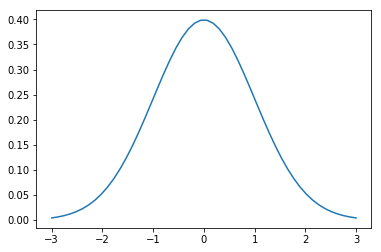

In [6]:
x = np.linspace(-3, 3, 50, dtype='float32')
density_variables = normal.prob(x).eval()

plt.plot(x, density_variables)

平均が0, 分散が1の正規分布がプロットされていることが確認できる

2次元の正規分布でもやってみる

In [7]:
loc_2d = [0.0, 0.0]
scale_2d = [1.0, 1.0]
normal_2d = Normal(loc_2d, scale_2d)

In [8]:
# サンプリング
random_variable = normal_2d.eval()
print(random_variable)
    
# 1回サンプリングする, サイズに注意
print(normal_2d.sample(10).eval())

[-0.51271528 -0.92158532]
[[-0.84645987 -0.83386981]
 [-0.51751667 -2.02018714]
 [-0.25200364 -0.59645349]
 [ 0.38389641  0.71494716]
 [ 0.50964952 -0.08019188]
 [ 0.21478616 -0.35207248]
 [-1.04806578 -0.13342018]
 [ 1.76133478  0.77590019]
 [ 0.15599453  0.29920429]
 [ 0.03828177  1.81605542]]


3DはSurface Plotで

/Users/t.nishime/.pyenv/versions/anaconda-2.4.0/envs/edward/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


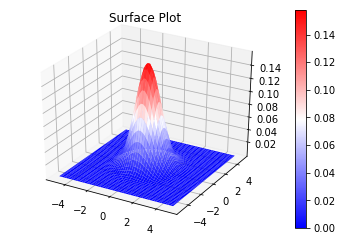

In [9]:
N = 50
x1 = np.linspace(-5, 5, N, dtype='float32')
x2 = np.linspace(-5, 5, N, dtype='float32')

X1, X2 = np.meshgrid(x1, x2)
X = np.c_[np.ravel(X1), np.ravel(X2)]

# X1, X2の確率密度を取得
density_variables_2d = normal_2d.prob(X).eval()

# 2d mapにするのでX1とX2の積を取る
density_variables_2d = density_variables_2d[:,0] * density_variables_2d[:,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X1, X2, density_variables_2d.reshape(X1.shape), cmap='bwr', linewidth=0)
fig.colorbar(surf)
ax.set_title("Surface Plot")
fig.show()

# ベルヌーイ分布でコイン投げモデルを定義してみる

ベルヌーイ分布は、確率$p$で1を、確率$1-p$で0を取る、離散確率分布である。

\begin{equation*}
Bernoulli(x|\mu) = \mu^kx(1-\mu)^{1-x}, x\in \{0, 1\}\\
P(x = 1) = \mu \\
P(x = 0) = 1 - \mu
\end{equation*}

In [10]:
# ベルヌーイ分布をインポート
# http://edwardlib.org/api/ed/models/Bernoulli
from edward.models import Bernoulli

In [11]:
x = Bernoulli(tf.ones(10)* 0.5).eval()
x

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1], dtype=int32)

# コイン投げモデルの事前分布を定義してみる
コインの裏と表が出る確率なので、確率変数が $0 \leq x \leq 1$ を取るような分布が良さそう

という事でベータ分布を使ってみる

In [12]:
from edward.models import Beta

In [13]:
concentration1 = 3
concentration0 = 2

beta = Beta(float(concentration1), float(concentration0))
random_variable_beta = beta.eval()

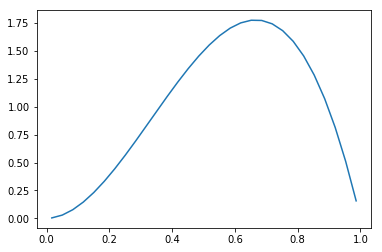

In [14]:
# ベータ分布をプロットする
x = np.linspace(-5, 5, 300, dtype='float32')
probability_density_variables_beta = Beta(float(concentration1), float(concentration0)).prob(x).eval()
probability_density_variables_beta2 = Beta(float(3.6), float(2.7)).prob(x).eval()


plt.plot(x, probability_density_variables_beta)

ベータ分布のハイパーパラメータを、$3,2$ に設定すると、若干表が出やすい分布が確認できる

<img src="beta_bernoulli_model.png">
コインの表裏は、ベルヌーイ分布からサンプリングされる。このコインの表が出る確率は、ベータ分布によって決定される。

In [15]:
def get_coinflip_model(concentration0, concentration1, n_data):
    p_mu = Beta(float(concentration1), float(concentration0))
    return Bernoulli(tf.ones(N)*p_mu)

In [16]:
model = get_coinflip_model(concentration1, concentration0, 10)

In [17]:
data = model.eval()
print("number of data:{}".format(len(data)))
print(data)
print("number of heads:{}".format(data.sum())) # 表の出た回数

number of data:50
[1 1 0 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1
 1 1 1 0 1 1 1 0 1 1 1 1 0]
number of heads:29
